In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [141]:
from sklearn.decomposition import PCA
from parameters import *
from lib.utils import *
from lib.attacks import *

In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)

In [180]:
from keras.models import load_model

model = load_model('../Adversarial-Examples-GAN/test_cnn_mnist.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [6]:
def get_angle(x):
    """
    Find 'similarity' of all members in x
    Define as <x1,x2> / (||x1||*||x2||)
    """
    
    len_x = len(x)
    diff = []
    for j in range(len_x):
        for k in range(len_x):
            if j != k:
                tmp = (np.dot(x[j].flatten(), x[k].flatten()) / 
                    (np.linalg.norm(x[j]) * np.linalg.norm(x[k])))
                diff.append(tmp)
    return np.array(diff)


def get_dist(x):
    """Get pairwise distance of all points in x"""
    
    x_flat = x.reshape(-1, N_FEATURE)
    len_x = len(x)
    diff = []
    for j in range(len_x):
        for k in range(len_x):
            if j != k:
                tmp = np.linalg.norm(x_flat[j] - x_flat[k])
                diff.append(tmp)
    return np.array(diff)


def get_loss(x, y_s, y_t):
    
    len_x = len(x)
    loss_s = np.zeros((len_x,))
    loss_t = np.zeros((len_x,))

    for j in range(len_x):
        x_cur = x_rnd[j].reshape((1,) + INPUT_SHAPE)
        loss_s[j] = model.evaluate(x_cur, y_s.reshape(1, 10), verbose=0)[0]
        loss_t[j] = model.evaluate(x_cur, y_t.reshape(1, 10), verbose=0)[0]
        
    return loss_s, loss_t

In [16]:
i = 10
x_s = x_test[i]
y_s = y_test[i]

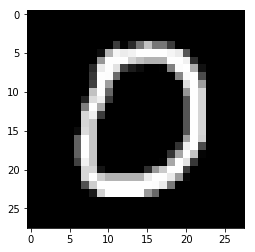

In [17]:
plt.imshow(x_s.reshape(28, 28), cmap='gray')

Test with `rnd_pgd`  
Pick one sample and one target label, repeatedly initialize a random point in a ball centered at the chosen sample. Perform projected gradient descent for a certain number of steps.

In [10]:
test_len = 1000
y_t = np.array([0])
y_t = keras.utils.to_categorical(y_t, NUM_LABELS)

x_rnd = np.zeros((test_len,) + INPUT_SHAPE)

for j in range(test_len):
    tmp = rnd_pgd(model, x_s.reshape((1,) + INPUT_SHAPE), y_t, 
                  norm="inf", n_step=40, step_size=0.01, target=True, init_rnd=0.1)
    x_rnd[j] = tmp

KeyboardInterrupt: 

In [ ]:
loss_s, loss_t = get_loss(x_rnd, y_s, y_t)

Histogram of loss with respect to the target label

In [ ]:
plt.hist(loss_t, bins=30)

Calculate the angle between all pairs of adversarial examples generated

In [9]:
diff = get_angle(x_rnd)

In [11]:
np.mean(diff)

0.89698024003700838

(array([  8.00000000e+00,   2.00000000e+01,   1.16000000e+02,
          2.80000000e+02,   6.38000000e+02,   1.52400000e+03,
          2.87800000e+03,   5.16200000e+03,   7.92000000e+03,
          1.13540000e+04,   1.58940000e+04,   2.08660000e+04,
          2.60860000e+04,   3.34420000e+04,   4.37380000e+04,
          5.66060000e+04,   7.21360000e+04,   8.83780000e+04,
          1.02178000e+05,   1.12102000e+05,   1.10002000e+05,
          9.89480000e+04,   7.78060000e+04,   5.41400000e+04,
          3.18040000e+04,   1.57640000e+04,   6.60400000e+03,
          2.09600000e+03,   4.62000000e+02,   4.80000000e+01]),
 array([ 0.80075926,  0.8059307 ,  0.81110213,  0.81627357,  0.821445  ,
         0.82661643,  0.83178787,  0.8369593 ,  0.84213074,  0.84730217,
         0.8524736 ,  0.85764504,  0.86281647,  0.86798791,  0.87315934,
         0.87833077,  0.88350221,  0.88867364,  0.89384508,  0.89901651,
         0.90418795,  0.90935938,  0.91453081,  0.91970225,  0.92487368,
         0.93

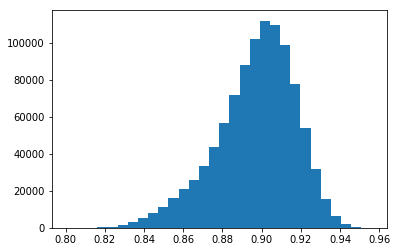

In [12]:
plt.hist(diff, bins=30)

Test `s_pgd`  

In [37]:
test_len = 1000
y_t = np.array([7])
y_t = keras.utils.to_categorical(y_t, NUM_LABELS)

x_rnd = np.zeros((test_len,) + INPUT_SHAPE)

for j in range(test_len):
    if j % 100 == 0:
        print(j)
    tmp = s_pgd(model, x_s.reshape((1,) + INPUT_SHAPE), y_t,  
                norm="inf", n_step=40, step_size=0.01, 
                target=True, beta=0.5, early_stop=True)
    x_rnd[j] = tmp

0
100
200
300
400
500
600
700
800
900


In [39]:
import pickle
pickle.dump(x_rnd, open("save_0.5_i10_t7.p", "wb"))
#x_rnd = pickle.load(open("save_0.5_i10_t7.p", "rb"))

In [18]:
diff = get_angle(x_rnd)

(array([  2.00000000e+00,   2.00000000e+00,   1.20000000e+01,
          3.60000000e+01,   9.00000000e+01,   2.06000000e+02,
          4.52000000e+02,   1.06600000e+03,   2.11800000e+03,
          3.93000000e+03,   7.80000000e+03,   1.34560000e+04,
          2.24280000e+04,   3.40240000e+04,   4.97180000e+04,
          6.87960000e+04,   8.74260000e+04,   1.05580000e+05,
          1.17078000e+05,   1.20202000e+05,   1.11258000e+05,
          9.39680000e+04,   7.10540000e+04,   4.59640000e+04,
          2.53320000e+04,   1.15120000e+04,   4.17800000e+03,
          1.13200000e+03,   1.54000000e+02,   2.60000000e+01]),
 array([ 0.96488814,  0.96583756,  0.96678698,  0.9677364 ,  0.96868582,
         0.96963524,  0.97058466,  0.97153408,  0.9724835 ,  0.97343292,
         0.97438234,  0.97533176,  0.97628118,  0.9772306 ,  0.97818002,
         0.97912944,  0.98007886,  0.98102828,  0.9819777 ,  0.98292712,
         0.98387654,  0.98482596,  0.98577538,  0.9867248 ,  0.98767422,
         0.98

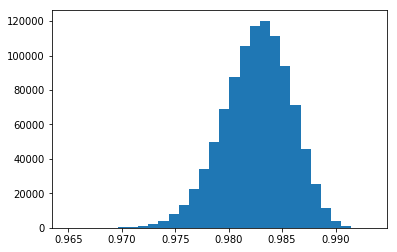

In [19]:
# step_size, beta = 0.01, 0.2
plt.hist(diff, bins=30)

Calculate histogram and variance of angle difference for uniformly random points in \[0, 1\]

Variance:  0.000125037195272


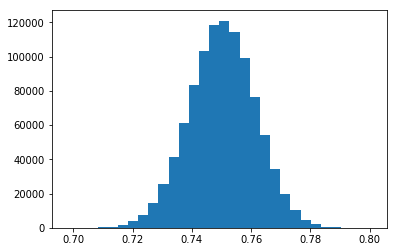

In [14]:
h, w, c = x_test[0].shape
len_rnd = 1000

rnd = np.random.rand(len_rnd, h, w, c)
diff = get_angle(rnd)
plt.hist(diff, bins=30)
print("Variance: ", np.var(diff))

Estimate hyperplane to fit all generated adversarial examples  
Try fitting with adversarial examples from (`n_step=40, step_size=0.01, beta=0.2`)

In [20]:
pca = PCA(n_components=783)
x_flat = x_rnd.reshape((-1, 784))
pca.fit(x_flat - np.mean(x_flat, axis=0))

proj_matrix = np.dot(pca.components_.T, pca.components_)
x_tran = np.dot(x_flat, proj_matrix)

In [ ]:
plt.hist(np.linalg.norm(x_tran - x_flat.reshape(-1, 784), axis=1), bins=30)

(array([  1.,   2.,   3.,   6.,   9.,  13.,  12.,  33.,  39.,  44.,  51.,
         64.,  53.,  59.,  90.,  69.,  69.,  86.,  61.,  58.,  46.,  46.,
         31.,  21.,  14.,   7.,   8.,   1.,   2.,   2.]),
 array([ 3.67595954,  3.68642543,  3.69689132,  3.70735722,  3.71782311,
         3.728289  ,  3.73875489,  3.74922078,  3.75968668,  3.77015257,
         3.78061846,  3.79108435,  3.80155024,  3.81201613,  3.82248203,
         3.83294792,  3.84341381,  3.8538797 ,  3.86434559,  3.87481149,
         3.88527738,  3.89574327,  3.90620916,  3.91667505,  3.92714095,
         3.93760684,  3.94807273,  3.95853862,  3.96900451,  3.9794704 ,
         3.9899363 ]),
 <a list of 30 Patch objects>)

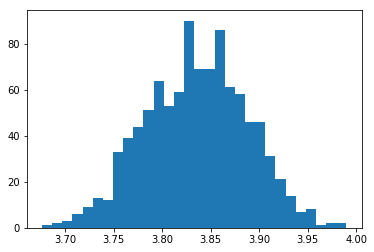

In [21]:
plt.hist(np.linalg.norm(x_tran - x_s.reshape(1, 784), axis=1), bins=30)

In [22]:
x_s_proj = np.dot(x_s.reshape(1, 784), proj_matrix)
print("Distance from original sample to hyperplane:", np.linalg.norm(x_s_proj - x_s.reshape(1, 784), axis=1)[0])

Distance from original sample to hyperplane: 0.00154478231123


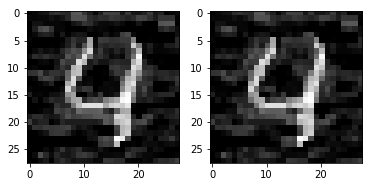

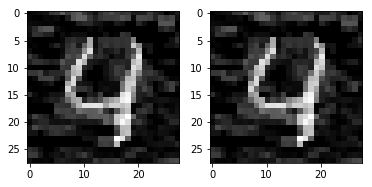

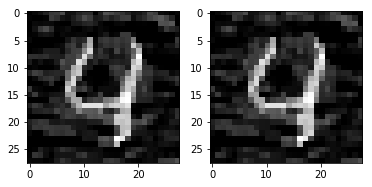

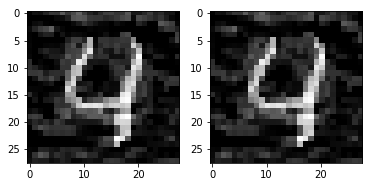

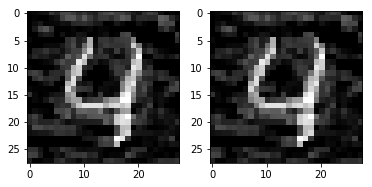

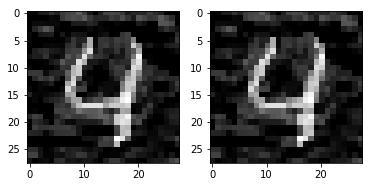

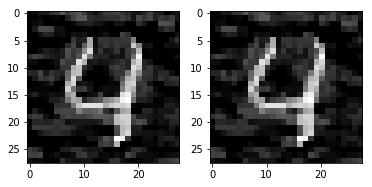

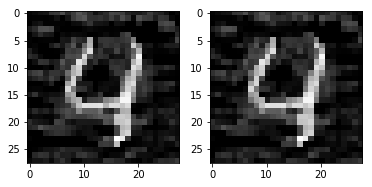

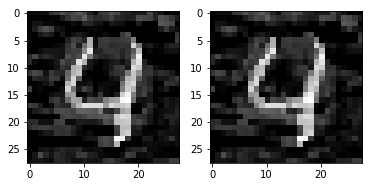

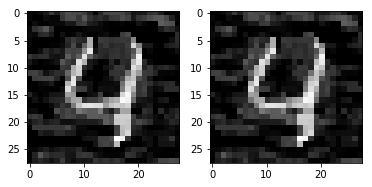

In [24]:
for j in range(10):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x_rnd[j].reshape(28, 28), cmap='gray')
    ax2.imshow(x_tran[j].reshape(28, 28), cmap='gray')
    plt.show()

Look like adversarial examples generated are very close to one another, resulting in the hyperplane overfitting a dense cluster of points. Or alternatively, the boundary is highly nonlinear and the approximation just does not work.  

#### beta = 0.5

(array([  1.40000000e+01,   4.20000000e+01,   6.20000000e+01,
          1.36000000e+02,   2.92000000e+02,   4.66000000e+02,
          9.38000000e+02,   1.62600000e+03,   3.19400000e+03,
          5.57600000e+03,   9.72000000e+03,   1.70480000e+04,
          2.80100000e+04,   4.35520000e+04,   6.36100000e+04,
          8.60480000e+04,   1.06942000e+05,   1.23040000e+05,
          1.27436000e+05,   1.19210000e+05,   9.91140000e+04,
          7.37680000e+04,   4.68300000e+04,   2.54600000e+04,
          1.13800000e+04,   4.14600000e+03,   1.06200000e+03,
          2.20000000e+02,   5.60000000e+01,   2.00000000e+00]),
 array([ 0.9503538 ,  0.95158116,  0.95280852,  0.95403589,  0.95526325,
         0.95649061,  0.95771797,  0.95894533,  0.9601727 ,  0.96140006,
         0.96262742,  0.96385478,  0.96508215,  0.96630951,  0.96753687,
         0.96876423,  0.96999159,  0.97121896,  0.97244632,  0.97367368,
         0.97490104,  0.97612841,  0.97735577,  0.97858313,  0.97981049,
         0.98

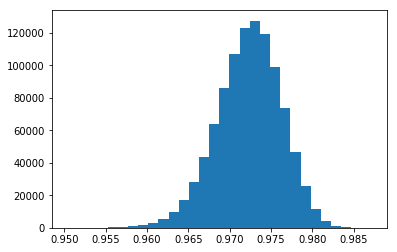

In [24]:
# step_size, beta = 0.01, 0.5
diff = get_angle(x_rnd)
plt.hist(diff, bins=30)

(array([   1.,    0.,    0.,    0.,    1.,    1.,    0.,    2.,    4.,
           4.,    6.,   11.,   18.,   27.,   41.,   60.,   89.,  105.,
         105.,  120.,  120.,   94.,   60.,   61.,   25.,   21.,   14.,
           4.,    3.,    3.]),
 array([ 3.4553959 ,  3.47659566,  3.49779542,  3.51899518,  3.54019494,
         3.5613947 ,  3.58259446,  3.60379422,  3.62499398,  3.64619374,
         3.6673935 ,  3.68859326,  3.70979302,  3.73099278,  3.75219254,
         3.7733923 ,  3.79459206,  3.81579182,  3.83699158,  3.85819134,
         3.8793911 ,  3.90059086,  3.92179062,  3.94299038,  3.96419014,
         3.9853899 ,  4.00658966,  4.02778942,  4.04898918,  4.07018894,
         4.0913887 ]),
 <a list of 30 Patch objects>)

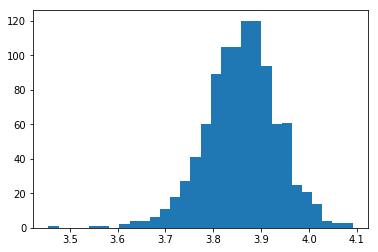

In [25]:
pca = PCA(n_components=783)
x_flat = x_rnd.reshape((-1, 784))
pca.fit(x_flat - np.mean(x_flat, axis=0))

proj_matrix = np.dot(pca.components_.T, pca.components_)
x_tran = np.dot(x_flat, proj_matrix)
plt.hist(np.linalg.norm(x_tran - x_s.reshape(1, 784), axis=1), bins=30)

In [26]:
x_s_proj = np.dot(x_s.reshape(1, 784), proj_matrix)
print("Distance from original sample to hyperplane:", np.linalg.norm(x_s_proj - x_s.reshape(1, 784), axis=1)[0])

Distance from original sample to hyperplane: 0.00273882584101


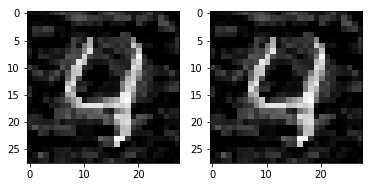

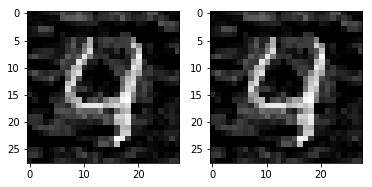

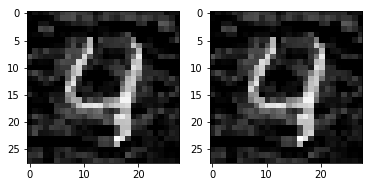

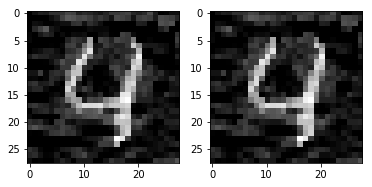

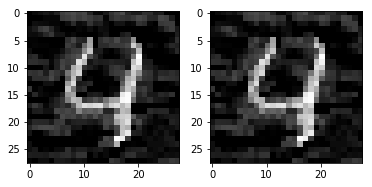

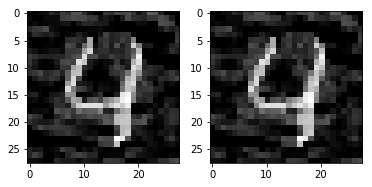

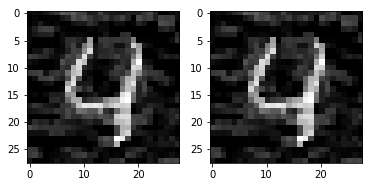

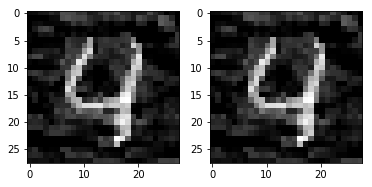

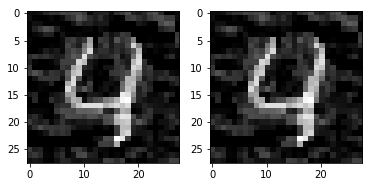

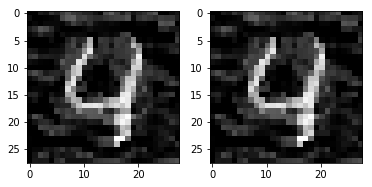

In [14]:
for j in range(10):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x_rnd[j].reshape(28, 28), cmap='gray')
    ax2.imshow(x_tran[j].reshape(28, 28), cmap='gray')
    plt.show()

Find distance between each pair of generated adversarial examples.

(array([  2.00000000e+00,   4.00000000e+00,   4.20000000e+01,
          1.26000000e+02,   4.42000000e+02,   1.41000000e+03,
          4.14800000e+03,   9.67000000e+03,   2.03220000e+04,
          3.60120000e+04,   5.83360000e+04,   8.29740000e+04,
          1.05048000e+05,   1.21668000e+05,   1.26512000e+05,
          1.18628000e+05,   1.00760000e+05,   7.80340000e+04,
          5.47900000e+04,   3.55580000e+04,   2.11320000e+04,
          1.15000000e+04,   6.11000000e+03,   3.16800000e+03,
          1.42000000e+03,   6.42000000e+02,   3.28000000e+02,
          1.42000000e+02,   5.80000000e+01,   1.40000000e+01]),
 array([ 1.20464865,  1.24454203,  1.28443541,  1.32432878,  1.36422216,
         1.40411554,  1.44400891,  1.48390229,  1.52379567,  1.56368904,
         1.60358242,  1.6434758 ,  1.68336917,  1.72326255,  1.76315593,
         1.8030493 ,  1.84294268,  1.88283606,  1.92272943,  1.96262281,
         2.00251619,  2.04240956,  2.08230294,  2.12219632,  2.16208969,
         2.20

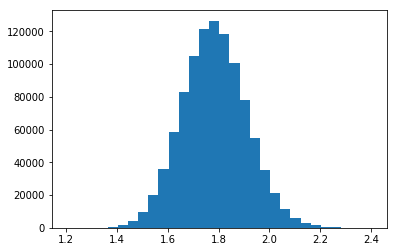

In [16]:
dist = get_dist(x_rnd)
plt.hist(a, bins=30)

Distance from each samples in `x_test` to the origin

In [20]:
dist_from_origin = np.zeros(len(x_test))
for j in range(len(x_test)):
    dist_from_origin[j] = np.linalg.norm(x_test[j].reshape(N_FEATURE))

(array([   2.,    7.,   23.,   40.,   75.,  142.,  196.,  265.,  368.,
         527.,  647.,  786.,  822.,  926.,  952.,  910.,  765.,  647.,
         559.,  444.,  319.,  187.,  142.,   91.,   65.,   44.,   24.,
          15.,    8.,    2.]),
 array([  3.67629433,   4.07176183,   4.46722933,   4.86269684,
          5.25816434,   5.65363185,   6.04909935,   6.44456685,
          6.84003436,   7.23550186,   7.63096937,   8.02643687,
          8.42190437,   8.81737188,   9.21283938,   9.60830688,
         10.00377439,  10.39924189,  10.7947094 ,  11.1901769 ,
         11.5856444 ,  11.98111191,  12.37657941,  12.77204692,
         13.16751442,  13.56298192,  13.95844943,  14.35391693,
         14.74938444,  15.14485194,  15.54031944]),
 <a list of 30 Patch objects>)

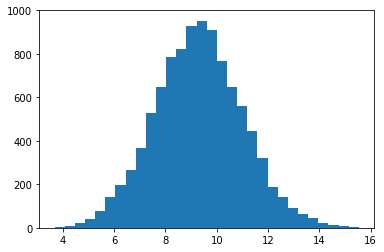

In [21]:
plt.hist(dist_from_origin, bins=30)

In [33]:
x_tran

array([[  1.99999996e-02,   3.99999917e-02,   6.99999779e-02, ...,
          2.40168780e-16,  -2.36139194e-17,   3.99999991e-02],
       [  1.31055134e-15,   1.01987490e-15,   5.49999811e-02, ...,
          1.04999997e-01,   1.95000023e-01,   1.85000002e-01],
       [  1.36092345e-15,   6.99999779e-02,   2.99999975e-02, ...,
          4.50000018e-02,   6.00000024e-02,   2.49999985e-02],
       ..., 
       [  1.25568369e-15,   6.99999854e-02,   7.99999908e-02, ...,
          2.04999983e-01,   2.04999983e-01,   1.25000000e-01],
       [  1.49999866e-02,   1.49999978e-02,   8.50000083e-02, ...,
          2.44999975e-01,   2.74999946e-01,   2.69999951e-01],
       [  1.37007167e-15,   1.35000035e-01,   1.14999980e-01, ...,
          2.09999979e-01,   2.94999927e-01,   3.29999924e-01]])

In [30]:
temp = pca.transform(x_rnd.reshape(-1, N_FEATURE))
x_tran_pca = pca.inverse_transform(temp)

In [32]:
x_tran_pca

array([[  1.99999996e-02,   3.99999917e-02,   6.99999779e-02, ...,
          2.50393929e-16,  -1.27575317e-16,   3.99999991e-02],
       [  1.34250099e-15,   9.33505217e-16,   5.49999811e-02, ...,
          1.04999997e-01,   1.95000023e-01,   1.85000002e-01],
       [  1.53975597e-15,   6.99999779e-02,   2.99999975e-02, ...,
          4.50000018e-02,   6.00000024e-02,   2.49999985e-02],
       ..., 
       [  1.27386055e-15,   6.99999854e-02,   7.99999908e-02, ...,
          2.04999983e-01,   2.04999983e-01,   1.25000000e-01],
       [  1.49999866e-02,   1.49999978e-02,   8.50000083e-02, ...,
          2.44999975e-01,   2.74999946e-01,   2.69999951e-01],
       [  1.40395398e-15,   1.35000035e-01,   1.14999980e-01, ...,
          2.09999979e-01,   2.94999927e-01,   3.29999924e-01]])

In [34]:
pca.explained_variance_ratio_

array([  4.49169406e-02,   4.26196810e-02,   2.82571165e-02,
         2.62812008e-02,   2.40845838e-02,   2.20811495e-02,
         2.01020847e-02,   1.90401496e-02,   1.75842392e-02,
         1.70564171e-02,   1.46409619e-02,   1.43071145e-02,
         1.33313195e-02,   1.17831988e-02,   1.11427511e-02,
         1.06101868e-02,   1.03341273e-02,   9.70102444e-03,
         9.48115883e-03,   8.95966005e-03,   8.65707620e-03,
         8.48322375e-03,   8.18564792e-03,   7.74703851e-03,
         7.60534815e-03,   7.11905447e-03,   6.84451280e-03,
         6.78405957e-03,   6.50515592e-03,   6.42492274e-03,
         6.25034008e-03,   6.19710669e-03,   5.96710707e-03,
         5.73503193e-03,   5.63485255e-03,   5.46853210e-03,
         5.37253039e-03,   5.33891792e-03,   5.32407572e-03,
         5.00680119e-03,   4.96869900e-03,   4.76997584e-03,
         4.64321727e-03,   4.44725910e-03,   4.39235317e-03,
         4.34496552e-03,   4.25411839e-03,   4.12164029e-03,
         4.05183106e-03,

In [40]:
diff = get_angle(x_rnd)

(array([  1.00000000e+01,   3.40000000e+01,   1.54000000e+02,
          4.34000000e+02,   9.34000000e+02,   2.18400000e+03,
          4.41600000e+03,   8.16200000e+03,   1.28100000e+04,
          1.93800000e+04,   2.75140000e+04,   3.72280000e+04,
          4.81060000e+04,   5.80900000e+04,   6.89900000e+04,
          7.74920000e+04,   8.40260000e+04,   8.77160000e+04,
          8.75760000e+04,   8.39100000e+04,   7.56020000e+04,
          6.48960000e+04,   5.31800000e+04,   4.03440000e+04,
          2.69860000e+04,   1.64840000e+04,   8.31400000e+03,
          3.14200000e+03,   7.88000000e+02,   9.80000000e+01]),
 array([ 0.94549228,  0.94703583,  0.94857938,  0.95012293,  0.95166648,
         0.95321002,  0.95475357,  0.95629712,  0.95784067,  0.95938422,
         0.96092777,  0.96247131,  0.96401486,  0.96555841,  0.96710196,
         0.96864551,  0.97018906,  0.97173261,  0.97327615,  0.9748197 ,
         0.97636325,  0.9779068 ,  0.97945035,  0.9809939 ,  0.98253744,
         0.98

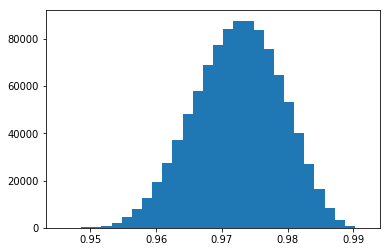

In [41]:
plt.hist(diff, bins=30)

(array([   1.,    0.,    2.,    1.,   16.,   25.,   25.,   43.,   76.,
          57.,   84.,   86.,  107.,   86.,   80.,   73.,   70.,   41.,
          37.,   27.,   25.,   18.,    8.,    5.,    5.,    1.,    0.,
           0.,    0.,    1.]),
 array([ 5.26082474,  5.27356707,  5.28630939,  5.29905171,  5.31179404,
         5.32453636,  5.33727868,  5.350021  ,  5.36276333,  5.37550565,
         5.38824797,  5.4009903 ,  5.41373262,  5.42647494,  5.43921727,
         5.45195959,  5.46470191,  5.47744424,  5.49018656,  5.50292888,
         5.51567121,  5.52841353,  5.54115585,  5.55389817,  5.5666405 ,
         5.57938282,  5.59212514,  5.60486747,  5.61760979,  5.63035211,
         5.64309444]),
 <a list of 30 Patch objects>)

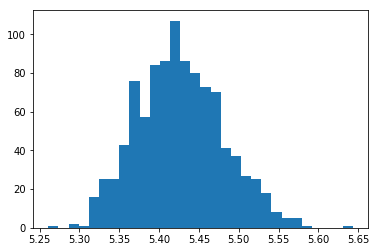

In [72]:
pca = PCA(n_components=700)
x_flat = x_rnd.reshape((-1, 784))
pca.fit(x_flat - np.mean(x_flat, axis=0))

proj_matrix = np.dot(pca.components_.T, pca.components_)
x_tran = np.dot(x_flat, proj_matrix)
plt.hist(np.linalg.norm(x_tran - x_s.reshape(1, 784), axis=1), bins=30)

In [73]:
x_s_proj = np.dot(x_s.reshape(1, 784), proj_matrix)
print("Distance from original sample to hyperplane:", np.linalg.norm(x_s_proj - x_s.reshape(1, 784), axis=1)[0])

Distance from original sample to hyperplane: 2.85569899993


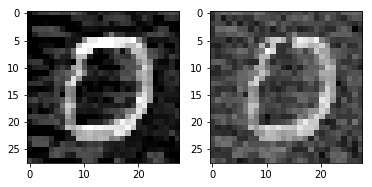

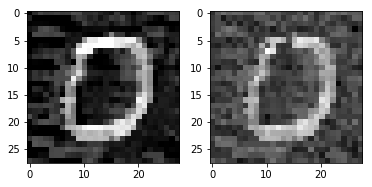

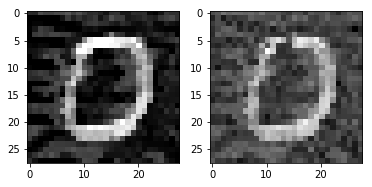

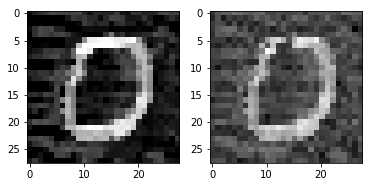

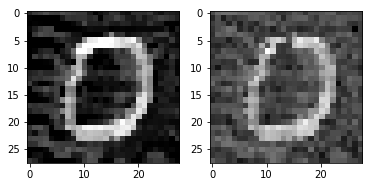

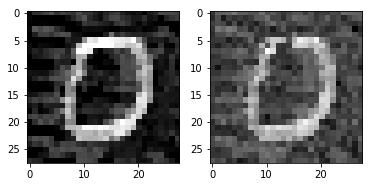

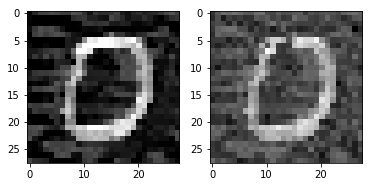

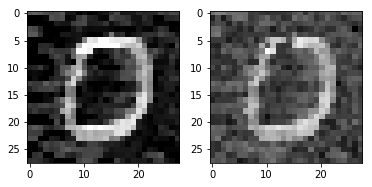

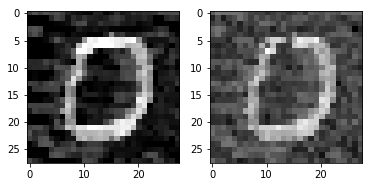

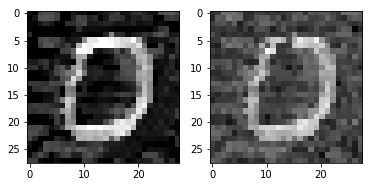

In [74]:
for j in range(10):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x_rnd[j].reshape(28, 28), cmap='gray')
    ax2.imshow(x_tran[j].reshape(28, 28), cmap='gray')
    plt.show()

(array([  2.80000000e+01,   1.26000000e+02,   4.82000000e+02,
          1.25800000e+03,   3.04000000e+03,   6.10200000e+03,
          1.04100000e+04,   1.69040000e+04,   2.51300000e+04,
          3.52900000e+04,   4.60740000e+04,   5.71440000e+04,
          6.78820000e+04,   7.84200000e+04,   8.58160000e+04,
          8.97600000e+04,   8.92520000e+04,   8.53640000e+04,
          7.72740000e+04,   6.61160000e+04,   5.39560000e+04,
          4.01880000e+04,   2.82560000e+04,   1.74960000e+04,
          1.02100000e+04,   4.62800000e+03,   1.68600000e+03,
          5.70000000e+02,   1.22000000e+02,   1.60000000e+01]),
 array([ 1.2153509 ,  1.27930018,  1.34324947,  1.40719875,  1.47114804,
         1.53509732,  1.59904661,  1.66299589,  1.72694518,  1.79089446,
         1.85484375,  1.91879303,  1.98274232,  2.0466916 ,  2.11064089,
         2.17459017,  2.23853946,  2.30248874,  2.36643803,  2.43038732,
         2.4943366 ,  2.55828589,  2.62223517,  2.68618446,  2.75013374,
         2.81

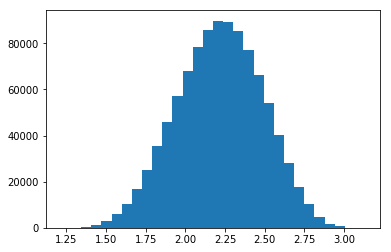

In [46]:
dist = get_dist(x_rnd)
plt.hist(dist, bins=30)

In [57]:
np.linalg.norm(x_tran - x_flat, axis=1)

array([ 0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26090621,
        0.26090621,  0.26090621,  0.26090621,  0.26090621,  0.26

(array([  1.,   0.,   1.,   2.,  12.,  24.,  28.,  38.,  69.,  63.,  74.,
         96.,  99.,  88.,  82.,  73.,  73.,  46.,  33.,  34.,  22.,  19.,
         11.,   5.,   3.,   3.,   0.,   0.,   0.,   1.]),
 array([ 4.55675121,  4.57128191,  4.58581261,  4.6003433 ,  4.614874  ,
         4.62940469,  4.64393539,  4.65846609,  4.67299678,  4.68752748,
         4.70205818,  4.71658887,  4.73111957,  4.74565027,  4.76018096,
         4.77471166,  4.78924235,  4.80377305,  4.81830375,  4.83283444,
         4.84736514,  4.86189584,  4.87642653,  4.89095723,  4.90548792,
         4.92001862,  4.93454932,  4.94908001,  4.96361071,  4.97814141,
         4.9926721 ]),
 <a list of 30 Patch objects>)

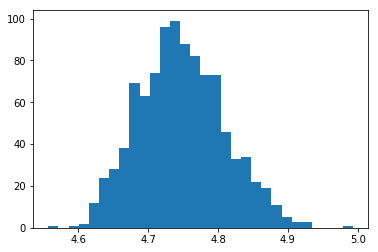

In [58]:
plt.hist(np.linalg.norm(x_tran - x_s.reshape(1, 784), axis=1), bins=30)

(array([  1.,   0.,   1.,   2.,  12.,  24.,  28.,  38.,  69.,  63.,  74.,
         96.,  99.,  88.,  82.,  73.,  73.,  46.,  33.,  34.,  22.,  19.,
         11.,   5.,   3.,   3.,   0.,   0.,   0.,   1.]),
 array([ 4.55126662,  4.5658133 ,  4.58035998,  4.59490665,  4.60945333,
         4.624     ,  4.63854668,  4.65309335,  4.66764003,  4.6821867 ,
         4.69673338,  4.71128005,  4.72582673,  4.74037341,  4.75492008,
         4.76946676,  4.78401343,  4.79856011,  4.81310678,  4.82765346,
         4.84220013,  4.85674681,  4.87129348,  4.88584016,  4.90038684,
         4.91493351,  4.92948019,  4.94402686,  4.95857354,  4.97312021,
         4.98766689]),
 <a list of 30 Patch objects>)

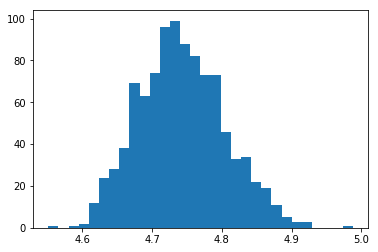

In [59]:
plt.hist(np.linalg.norm(x_rnd.reshape(-1, 784) - x_s.reshape(1, 784), axis=1), bins=30)

---

In [7]:
model.layers

In [8]:
from keras import backend as K

# input placeholder
inp = model.input 
# Output of second-to-last layer
out = model.layers[5].output
# evaluation functions
eval_fnc = K.function([inp, K.learning_phase()], [out])

In [9]:
# Testing
x = x_test[0][np.newaxis, ...]
layer_outs = eval_fnc([x, 0])
print(layer_outs)

[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.67312407,  3.78914928,  0.        ,  0.        ,  2.56387568,
         3.3312068 ,  1.91257739,  0.        ,  1.93400908,  0.        ,
         0.        ,  0.        ,  2.8909266 ,  0.        ,  0.        ,
         2.35000515,  0.        ,  0.        ,  0.        ,  2.72177529,
         2.98210478,  2.29121685,  0.        ,  1.98073077,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.72890234,
         2.23965049,  0.        ,  2.08872056,  1.8678807 ,  0.        ,
         0.        ,  1.80429077,  0.        ,  0.        ,  3.66508579,
         0.62776995,  1.84535694,  0.        ,  1.8484062 ,  2.83016562,
         0.        ,  2.74846768,  0.        ,  0.        ,  3.29759502,
         0.        ,  2.26741266,  0.        ,  0.        ,  2.83797765,
         0.        ,  3.05007672,  0.        ,  0.        ,  4.9599967 ,
         0.        ,  0.        ,  0.        ,  0.

In [10]:
n_feat = 128
x_nn_train = np.zeros((len(x_train), n_feat))
x_nn_test = np.zeros((len(x_test), n_feat))

for i, x in enumerate(x_train):
    x_in = x[np.newaxis, ...]
    layer_outs = eval_fnc([x_in, 0])
    x_nn_train[i] = layer_outs[0][0]
    
for i, x in enumerate(x_test):
    x_in = x[np.newaxis, ...]
    layer_outs = eval_fnc([x_in, 0])
    x_nn_test[i] = layer_outs[0][0]

In [11]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(x_nn_train, np.argmax(y_train, axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
clf.score(x_nn_test, np.argmax(y_test, axis=1))

0.98929999999999996

In [13]:
w = clf.coef_
b = clf.intercept_

In [144]:
# Pop last layer out of cnn
model.layers.pop()

In [145]:
from keras import Model

new_layer = Dense(1, activation='linear', name='new_layer')

inp = model.input
out = new_layer(model.layers[-1].output)

model2 = Model(inp, out)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
__________

In [146]:
i = 27
model2.layers[-1].set_weights([w[i].reshape((n_feat, 1)), b[i].reshape(1)])

In [106]:
# y_sum = np.zeros(10)

# for i, x in enumerate(x_test):
#     y = model2.predict(x[np.newaxis, ...])[0][0]
#     y_sum[np.argmax(y_test[i])] += y

In [17]:
x_3 = []
x_7 = []

for i, x in enumerate(x_test):
    if np.argmax(y_test[i]) == 3:
        x_3.append(x)
    elif np.argmax(y_test[i]) == 7:
        x_7.append(x)
        
x_3 = np.array(x_3)
x_7 = np.array(x_7)
print(x_3.shape, x_7.shape)

(1010, 28, 28, 1) (1028, 28, 28, 1)


In [143]:
def custom_grad_fn(model):
    """Return gradient function of model's loss w.r.t. input"""

#     x_in = K.placeholder(dtype=tf.float32, shape=INPUT_SHAPE)
#     y_true = K.placeholder(shape=(OUTPUT_DIM, ))
#     loss = K.categorical_crossentropy(y_true, model(x_in)[0], from_logits=False)
#     grad = K.gradients(loss, x_in)

#     return K.function([x_in, y_true, K.learning_phase()], grad)
   
    y_true = K.placeholder(shape=(OUTPUT_DIM, ))
    loss = K.categorical_crossentropy(y_true, model.output, from_logits=False)
    grad = K.gradients(loss, model.input)

    return K.function([model.input, y_true, K.learning_phase()], grad)


def custom_grad_fn2(model):
    """Return gradient function of model's loss w.r.t. input"""

    y_true = K.placeholder(shape=(1, ))
    # mean_absolute_error
    # mean_squared_error
    # hinge
    # binary_crossentropy
    loss = keras.losses.mean_absolute_error(y_true, model.output)
    grad = K.gradients(loss, model.input)

    return K.function([model.input, y_true, K.learning_phase()], grad)


def test_s_pgd(model, x, y, norm="2", n_step=40, step_size=0.01, target=True,
          mask=None, beta=0.1, early_stop=True, grad_fn=None):
    """
    Projected gradient descent with added randomness during each step
    """

    x_adv = np.zeros_like(x)
    if grad_fn is None:
        grad_fn = gradient_fn(model)
    start_time = time.time()

    for i, x_in in enumerate(x):

        x_cur = np.copy(x_in)
        # Get mask with the same shape as gradient
        if mask is not None:
            mask_rep = np.repeat(mask[i, :, :, np.newaxis], N_CHANNEL, axis=2)

        # Start update in steps
        for _ in range(n_step):

            # Get gradient
            if target is not None:
                grad = -1 * gradient_input(grad_fn, x_cur, y[i])
            else:
                grad = gradient_input(grad_fn, x_cur, y[i])

            # Get uniformly random direction
            h, w, c = x_cur.shape
            epsilon = np.random.rand(h, w, c) - 0.5

            if norm == "2":
                try:
                    grad /= np.linalg.norm(grad)
                    epsilon /= np.linalg.norm(epsilon)
                except ZeroDivisionError:
                    raise
            elif norm == "inf":
                grad = np.sign(grad)
                epsilon = np.sign(epsilon)
            else:
                raise ValueError("Invalid norm!")

            # Apply mask
            if mask is not None:
                grad *= mask_rep
                epsilon += mask_rep

            x_cur += (grad * step_size + beta * epsilon * step_size)
            # Clip to stay in range [0, 1]
            x_cur = np.clip(x_cur, 0, 1)

            if early_stop:
                # Stop when sample becomes adversarial
                if model.predict(x_cur[np.newaxis, ...])[0][0] < 0:
                    break

        x_adv[i] = x_cur

        # Progress printing
        if (i % 200 == 0) and (i > 0):
            elasped_time = time.time() - start_time
            print("Finished {} samples in {:.2f}s.".format(i, elasped_time))
            start_time = time.time()

    return x_adv


def test_fg(model, x, y, mag_list, target=True, mask=None):
    """
    Fast Gradient attack. Similar to iterative attack but only takes one step
    and then clip result afterward.

    Parameters
    ----------
    model    : Keras Model
               Model to attack
    x        : np.array, shape=(n_sample, height, width, n_channel)
               Benign samples to attack
    y        : np.array, shape=(n_sample, NUM_LABELS)
               Target label for each of the sample in x if target is True.
               Otherwise, corresponding labels of x. Must be one-hot encoded.
    mag_list : list of float
               List of perturbation magnitude to use in the attack
    target   : (optional) bool
               True, if targeted attack. False, otherwise.
    mask     : (optional) np.array of 0 or 1, shape=(n_sample, height, width)
               Mask to restrict gradient update on valid pixels

    Return
    ------
    x_adv    : np.array, shape=(n_mag, n_sample, height, width, n_channel)
               Adversarial examples
    """

    x_adv = np.zeros((len(mag_list), ) + x.shape, dtype=np.float32)
    grad_fn = custom_gradient_fn2(model)
    start_time = time.time()

    for i, x_in in enumerate(x):

        # Retrieve gradient
        if target:
            grad = -1 * gradient_input(grad_fn, x_in, y[i])
        else:
            grad = gradient_input(grad_fn, x_in, y[i])
        print(np.linalg.norm(grad))

        # Apply mask
        if mask is not None:
            mask_rep = np.repeat(mask[i, :, :, np.newaxis], N_CHANNEL, axis=2)
            grad *= mask_rep

        # Normalize gradient
        try:
            grad /= np.linalg.norm(grad)
        except ZeroDivisionError:
            raise

        for j, mag in enumerate(mag_list):
            x_adv[j, i] = x_in + grad * mag

        # Progress printing
        if (i % 1000 == 0) and (i > 0):
            elasped_time = time.time() - start_time
            print("Finished {} samples in {:.2f}s.".format(i, elasped_time))
            start_time = time.time()

    # Clip adversarial examples to stay in range [0, 1]
    x_adv = np.clip(x_adv, 0, 1)

    return x_adv

In [148]:
test_len = 100
grad_fn = custom_grad_fn2(model2)
# Reshape to (n_sample, output_dim)
y_t = np.array([-1] * test_len).reshape(-1, 1)

x_adv = test_s_pgd(model2, x_3[:test_len], y_t, norm="inf", 
                   n_step=40, step_size=0.01, target=False, beta=0, 
                   early_stop=True, grad_fn=grad_fn)

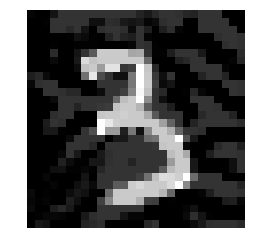

In [229]:
plt.imshow(x_adv[2].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.savefig('3_2.png', bbox_inches='tight')

In [158]:
n_suc = 0
dist = 0

for i, x in enumerate(x_adv):
    y = model2.predict(x[np.newaxis, ...])[0]
    if y < 0:
        n_suc += 1
        dist += np.linalg.norm(x_3[i] - x)

print(n_suc, dist / n_suc)

100 2.97069602907


In [207]:
grad_fn = custom_grad_fn(model)
y_t = np.array([7] * test_len)
y_t = keras.utils.to_categorical(y_t, 10)

x_adv_nn = s_pgd(model, x_3[:test_len], y_t, norm="inf", 
                 n_step=40, step_size=0.01, target=True, beta=0, 
                 early_stop=True, grad_fn=grad_fn)

3


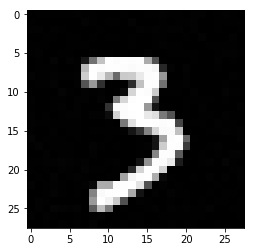

In [208]:
x = x_adv_nn[1]
plt.imshow(x.reshape(28, 28), cmap='gray')
print(np.argmax(model.predict(x[np.newaxis, ...])[0]))

In [210]:
n_suc = 0
n = 0
dist = 0

for i, x in enumerate(x_adv_nn):
    y = model.predict(x[np.newaxis, ...])[0]
    if x[0,0,0] == x[0,0,0]:
        n += 1
    else:
        continue
    if np.argmax(y) != 3:
        n_suc += 1
        dist += np.linalg.norm(x_3[i] - x)

print(n_suc, dist / n_suc)

36 3.01192386945


In [205]:
# Fix early_stop svm
# Adjust svm param C
model = load_model('../Adversarial-Examples-GAN/test_cnn_mnist.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [213]:
model.pop()

In [214]:
c = [0.00001]
svm = []

for i, C in enumerate(c):
    
    clf = SVC(kernel='linear', C=C)
    clf.fit(x_nn_train, np.argmax(y_train, axis=1))
    score = clf.score(x_nn_test, np.argmax(y_test, axis=1))
    print(C, score)

    w = clf.coef_
    b = clf.intercept_

    new_layer = Dense(1, activation='linear', name='new_layer')

    inp = model.input
    out = new_layer(model.layers[-1].output)

    tmp = Model(inp, out)
    tmp.layers[-1].set_weights([w[27].reshape((n_feat, 1)), b[27].reshape(1)])
    
    svm.append(tmp)

1e-05 0.9871


In [177]:
n = 0
n_cor = 0

for i, x in enumerate(x_test):
    y = svm[0].predict(x[np.newaxis,...])[0][0]
    y_ = np.argmax(y_test[i])
    if y_ == 3:
        n += 1
        if y > 0:
            n_cor += 1
    elif y_ == 7:
        n += 1
        if y < 0:
            n_cor += 1
    else:
        continue
print(n, n_cor, n_cor / float(n))

2038 2034 0.9980372914622179


In [215]:
y_t = np.array([-1] * test_len).reshape(-1, 1)

for clf in svm:
    
    grad_fn = custom_grad_fn2(clf)
    # Reshape to (n_sample, output_dim)
    x_adv = test_s_pgd(clf, x_3[:test_len], y_t, norm="inf", 
                       n_step=40, step_size=0.01, target=False, beta=0, 
                       early_stop=True, grad_fn=grad_fn)
    
    n_suc = 0
    dist = 0
    for i, x in enumerate(x_adv):
        y = clf.predict(x[np.newaxis, ...])[0]
        if y < 0:
            n_suc += 1
            dist += np.linalg.norm(x_3[i] - x)

    print(n_suc, dist / n_suc)

100 3.02843365982


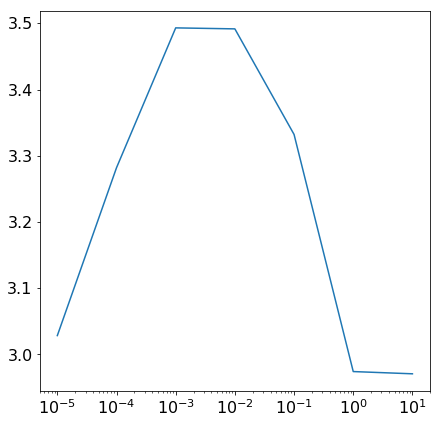

In [220]:
c = [0.00001,0.0001,0.001,0.01,0.1,1,10]
dist = [3.02843365982, 3.28195833027, 3.49320551276, 
        3.4917006731, 3.33224222422, 2.97408321261, 
        2.97069602907]

plt.figure(figsize=(7,7))
plt.semilogx(c, dist)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('dist.png', bbox_inches='tight')
plt.show()

In [179]:
model.layers[-1]

In [194]:
weight = model.layers[-1].get_weights()
model.pop()
new_layer = Dense(10, activation='linear', name='new_layer')
inp = model.input
out = new_layer(model.layers[-1].output)
model = Model(inp, out)
model.layers[-1].set_weights(weight)

In [201]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
__________

------

In [7]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 117us/step - loss: 0.3474 - acc: 0.8931 - val_loss: 0.0806 - val_acc: 0.9747
Epoch 2/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.1185 - acc: 0.9652 - val_loss: 0.0575 - val_acc: 0.9807
Epoch 3/12
60000/60000 [==============================] - 5s 81us/step - loss: 0.0885 - acc: 0.9730 - val_loss: 0.0427 - val_acc: 0.9853
Epoch 4/12
60000/60000 [==============================] - 5s 84us/step - loss: 0.0737 - acc: 0.9782 - val_loss: 0.0391 - val_acc: 0.9864
Epoch 5/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0636 - acc: 0.9812 - val_loss: 0.0368 - val_acc: 0.9876
Epoch 6/12
60000/60000 [==============================] - 5s 80us/step - loss: 0.0586 - acc: 0.9827 - val_loss: 0.0333 - val_acc: 0.9882
Epoch 7/12
60000/60000 [==============================

In [9]:
model.save('../Adversarial-Examples-GAN/test_cnn_mnist.h5')